In [1]:
import pandas as pd
import numpy as np
import csv
import re
import string
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import string, math

plate_1 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate1.csv"
plate_1_repeat = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate1_repeat.csv"
plate_2_1 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate2_1.csv"
plate_2_2 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate2_2.csv"
plate_2_3 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate2_3.csv"
plate_2_repeat = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate2_repeat.csv"
plate_2_repeat_96 = "C:\\Users\\Bartek\\Documents\\MFluorescence-Anisotropy-Analysis\\tests\\Test data\\plate2_repeat _96.csv"
list_A = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listA.csv"
list_A_repeat = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listA_repeat.csv"
list_B = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listB.csv"
list_B_repeat_end = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listB_repeat _end.csv"
list_B_repeat_96 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listB_repeat _96.csv"
list_C = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listC.csv"

plate_map_file = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\plate_map.csv"

class Error(Exception):
    pass
class PlateMapError(Error):
    pass
class HeaderError(PlateMapError):
    pass

header_names = {'Well ID': {'dtype':str, 'long':True, 'short_row': False, 'short_col':False},
                'Type': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Contents': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Protein Name': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Protein Concentration': {'dtype':float, 'long':True, 'short_row': True, 'short_col':True},
                'Tracer Name': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Tracer Concentration': {'dtype':float, 'long':True, 'short_row': True, 'short_col':True},
                'Competitor Name': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Competitor Concentration': {'dtype':float, 'long':True, 'short_row': True, 'short_col':True},
                'Concentration Units':{'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
               }

wells = {6:(2, 3), 12:(3, 4), 24:(4, 6), 48:(6, 8), 96:(8, 12), 384:(16, 24)}

#data_types = {'Well ID' : str, 'Compound' : str, 'Protein': str, 'Concentration' : float, 'Concentration Units' : str,
#             'Contents' : str, 'Type' : str, 'Valid' : bool}

In [43]:
def empty_map(size=384, valid=True):
    
    headers = [x for x in header_names.keys() if header_names[x]['long']]
    
    row_letters = list(string.ascii_uppercase)[0: wells[size][0]] 
    col_numbers = list(np.arange(1, wells[size][1] + 1).astype(str))  
    well_ids = ['%s%s' % (item[0], item[1]) for item in product(row_letters, col_numbers)]
    
    empty_df = pd.DataFrame(index=well_ids, columns=headers)
    
    empty_df['Valid'] = valid
    
    if 'Type' in empty_df.columns:
        empty_df['Type'] = 'empty'
    
    empty_df.drop(labels='Well ID', axis=1, inplace=True)
    
    return empty_df



def plate_map(file, size = 96, valid = True):
    """Returns a dataframe from a 'long' plate map csv file that defines each and every well from a well plate of defined size
    
    Each defined well in the csv file corresponds to a row of the dataframe. The index is set to the Well ID's of the well plate, e.g. "A1". Dataframe contains headers such as 'Well ID', 'Compound', 'Protein', 'Concentration', 'Concentration Units', 'Contents', 'Type' and 'Valid'. The csv file contains headers on line 2 and a well ID in the first column for every well in the plate.
    An example csv template can be found here: 'long map example.csv'
    
    :param size: Size of well plate - 6, 12, 24, 48, 96 or 384, default = 96 
    :param type: int
    :param valid: Validates every well - 'True' sets every well as valid, 'False' wells will not be used for analysis, default = True
    :type valid: bool
    :return: Pandas Dataframe of a defined plate map
    """
    try:
        # substitute values w/ new plate map
        data_types = {i[0]: i[1]['dtype'] for i in header_names.items()}
        
        df = pd.read_csv(file, skiprows = 1, dtype = data_types, skipinitialspace = True)
        headers = [x for x in header_names.keys() if header_names[x]['long']]
        if set(list(df.columns)) != set(headers):
            raise HeaderError("Wrong headers!")

        # set index to Well ID
        df = df.set_index(df['Well ID'])

        # check there are no repeats
        if len(df.index.unique()) != len(df.index):
            raise PlateMapError("Check your plate map!")

        # correct typos due to capitalisation and trailing spaces
        if 'Type' in df.columns:    
            df['Type'] = df['Type'].str.lower()
        str_cols = [x for x in header_names.keys() if header_names[x]['dtype']==str]
        df[str_cols] = df[str_cols].stack().str.rstrip().unstack()

        # define empty plate map
        temp = empty_map(size = size, valid = valid)

        # insert plate map into empty map
        temp.update(df)

        return temp
    
    except HeaderError: 
        print("Headers in csv file are incorrect.\nUse: {}".format(headers))
    except PlateMapError:
        print("Check your plate map! Incorrect number of wells.")



# The next 3 functions are used to simplify 'visualise' function that follows: 

# hatches are defined to clearly show invalidated wells
hatchdict = {"True":("", 'black'), "False":("//////", 'red')}

# fontsize will scale font size of visualisaiton to the well plate size (avoids overlapping text)
def fontsize(sizeby, plate_size): 
    """Returns a font size defined by the length of the string and size of the well plate
    
    Larger well plate and/or longer string = smaller font size.
    
    :param sizeby: String that requires a corresponding font size
    :type sizeby: String or list of strings
    :param plate_size: Scalable integer, the size of the well plate
    :var plate_size: Larger value corresponds with smaller fontsize, size of well plate is used in the following instances of the function
    :type plate_size: int
    :return: float corresponding to a scaled font size 
    :rtype: float
    """
    return (8 - math.log10(len(str(sizeby)))*2 - math.log10(plate_size)*1.5)

# adds labels according to label stipulations (avoids excessive if statements in the visualise function)
def labelwell(platemap, labelby, iterrange):
    """Returns label for each row of a stipulated column.
    
    Used to return the appropriate, formatted label from a specified platemap at every well. Empty wells will always return 'empty', wells without a label will return a blank string.  
    
    :param platemap: Platemap that contains the required labels
    :type platemap: pandas dataframe
    :param labelby: Dataframe column to label by, for example 'Compound', 'Protein', 'Concentration', 'Concentration Units', 'Contents' or 'Type'
    :type labelby: str
    :param iterrange: Number of instances to itterate over, typically the size of the platemap
    :type iterrange: int
    """
    if platemap['Type'].iloc[iterrange] == 'empty':
        return "empty"
    elif str(platemap[labelby].iloc[iterrange]) != 'nan':
        return str(platemap[labelby].iloc[iterrange]).replace(" ", "\n")
    else:
        return " "
    
def wellcolour(platemap, colorby, cmap, iterrange):
    """Returns a unique colour for each label or defined condition.
    
    Wellcolour generates a dictionary of colours for each unique label. This can be used to colour code figures to a defined label. 
    
    :param platemap: Platemap that contains the required labels
    :type platemap: pandas dataframe
    :param colorby: Dataframe column to colour code, for example 'Compound', 'Protein', 'Concentration', 'Concentration Units', 'Contents' or 'Type'
    :type colorby: str
    :type cmap: Colour map that generates a customisable list of colours
    :param iterrange: Number of instances to itterate over, typically the size of the platemap
    :type iterrange: int
    :return: RGB array of a colour that corresponds to a unique label
    :rtype: numpy array
    """
    # unique strings in the defined column are used as the list of labels, converted to strings to avoid errors.
    types = [str(i) for i in list(platemap[colorby].unique())]
    cmap = plt.get_cmap(cmap)
    # get equally spaced colour values
    colors = cmap(np.linspace(0, 1, len(types)))
    colordict = dict(zip(types, colors))
    colordict['nan'] = 'yellow'
    color = colordict.get(str(platemap[colorby].iloc[iterrange]))
    return color




def visualise(platemap, title = "", size = 96, export = False, cmap = 'Paired',
             colorby = 'Type', labelby = 'Type', dpi = 150):
    """Returns a visual representation of the plate map.
    
    The label and colour for each well can be customised to be a variable, for example 'Compound', 'Protein', 'Concentration', 'Concentration Units', 'Contents' or 'Type'. The size of the plate map used to generate the figure can be either 6, 12, 24, 48, 96 or 384. 
    
    :param platemap: Plate map to plot
    :type platemap: pandas dataframe
    :param size: Size of platemap, 6, 12, 24, 48, 96 or 384, default = 96
    :type size: int    
    :param export: If 'True' a .png file of the figure is saved, default = False
    :type export: bool
    :param title: Sets the title of the figure, optional
    :type title: str
    :param cmap: Sets the colormap for the color-coding, default = 'Paired'
    :type cmap: str
    :param colorby: Chooses the parameter to color code by, for example 'Type', 'Contents', 'Concentration', 'Compound', 'Protein', 'Concentration Units', default = 'Type'
    :type colorby: str
    :param labelby: Chooses the parameter to label code by, for example 'Type', 'Contents', 'Concentration', 'Compound', 'Protein', 'Concentration Units', default = 'Type'
    :type labelby: str
    :param dpi: Size of the figure, default = 150
    :type dpi: int
    :return: Visual representation of the plate map.
    :rtype: figure
    """
    try:
        fig = plt.figure(dpi = dpi)
        # define well plate grid according to size of well plate 
        # an extra row and column is added to the grid to house axes labels
        grid = gridspec.GridSpec((wells[size])[0]+1, (wells[size])[1]+1, wspace=0.1, hspace=0.1, figure = fig)

        # plot row labels in extra row
        for i in range(1, (wells[size])[0]+1):
            ax = plt.subplot(grid[i, 0])
            ax.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.text(0.5, 0.5, list(string.ascii_uppercase)[i-1], size = 8, ha = "center", va="center")

        # plot column labels in extra column
        for i in range(1, (wells[size])[1]+1):
            ax = plt.subplot(grid[0, i])
            ax.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.text(0.5, 0.5, list(range(1, (wells[size])[1]+1))[i-1], size = 8, ha = "center", va="center")
        
        indexes = list(platemap.index)
        coords = [(ord(item[0].lower()) - 96, int(item[1:])) for item in indexes]
                
        # plot plate types in grid, color code and label
        for i, coord in enumerate(coords):   
            ax = plt.subplot(grid[coord[0], coord[1]])
            ax.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            
            # Well colour coding  
            if platemap['Type'].iloc[i] == 'empty':
                ax.add_artist(plt.Circle((0.5, 0.5), 0.49, edgecolor='black', fill = False, lw=0.5))
                # LABELS #
                # add 'empty' label
                ax.text(0.5, 0.5, 'empty', size = str(fontsize(sizeby = 'empty', plate_size = size)), wrap = True, ha = "center", va="center")

            else:
                ax.add_artist(plt.Circle((0.5, 0.5), 0.49, facecolor=wellcolour(platemap, colorby, cmap, i), 
                    edgecolor=hatchdict[str(platemap['Valid'].iloc[i])][1], lw=0.5, hatch = hatchdict[str(platemap['Valid'].iloc[i])][0]))

                # LABELS 
                # nan option allows a blank label if there is nothing stipulated for this label condition
                if str(platemap[labelby].iloc[i]) != 'nan':
                    ax.text(0.5, 0.5, labelwell(platemap, labelby, i), 
                    size = str(fontsize(sizeby = platemap[labelby].iloc[i], plate_size = size)), wrap = True, ha = "center", va="center")
                    
        plt.suptitle(f"{title}")   # add the figure title

        if export == True:   # option to save the figure as .png file
            plt.savefig(f"{title}_map.png")
    
    except:
        print('error!')
        
        
        
def invalidate_wells(platemap, wells, valid = False):
    """Returns updated plate map with specified wells invalidated.
    
    :param platemap: Plate map to use
    :type platemap: pandas dataframe
    :param wells: Well or wells to invalidate, e.g. ("A1", "B1", "C1")   #works both if passed as a tuple of str and list of str
    :type wells: string or list of strings
    :param valid: Sets the stipulated well 'True' or 'False', default = False
    :type valid: bool
    :return: Returns updated plate map
    :rtype: pandas dataframe
    """
    platemap.loc[wells, 'Valid'] = valid 
    return platemap


def invalidate_rows(platemap, rows, valid = False):
    """Returns updated plate map with specified rows invalidated.
    
    :param platemap: Plate map to use
    :type platemap: pandas dataframe
    :param rows: Rows to invalidate, e.g. ("A", "B", "C")   # does not work (KeyError) if passed a list of str but works for a tuple of str
    :type rows: list of strings                             # startswith method can take only a str or tuple of strings as an argument
    :param valid: Sets the stipulated row or rows 'True' or 'False', default = False
    :type valid: bool
    :return: Returns updated plate map
    :rtype: pandas dataframe
    """
    if type(rows) == list:
        rows = tuple(rows)
        
    platemap.loc[platemap.index.str.startswith(rows), 'Valid'] = valid
    
    return platemap


def invalidate_cols(platemap, cols, valid = False):
    """Returns updated plate map with specified columns invalidated.
    
    :param platemap: Plate map to use
    :type platemap: pandas dataframe
    :param wells: Columns to invalidate, e.g. 1, 2, 3
    :type wells: int or list of ints
    :param valid: Sets the stipulated column or columns 'True' or 'False', default = False
    :type valid: bool
    :return: Returns updated plate map
    :rtype: pandas dataframe
    """
    if type(cols) == int:
        cols = [cols]

    all_ids = list(platemap.index)
    inval_ids = [item for item in all_ids if int(item[1:]) in cols]
    platemap.loc[inval_ids, 'Valid'] = valid
    
    return platemap

In [9]:
empty = empty_map(size=384, valid=True)

In [23]:
myplatemap = plate_map(plate_map_file, size=384, valid=True)

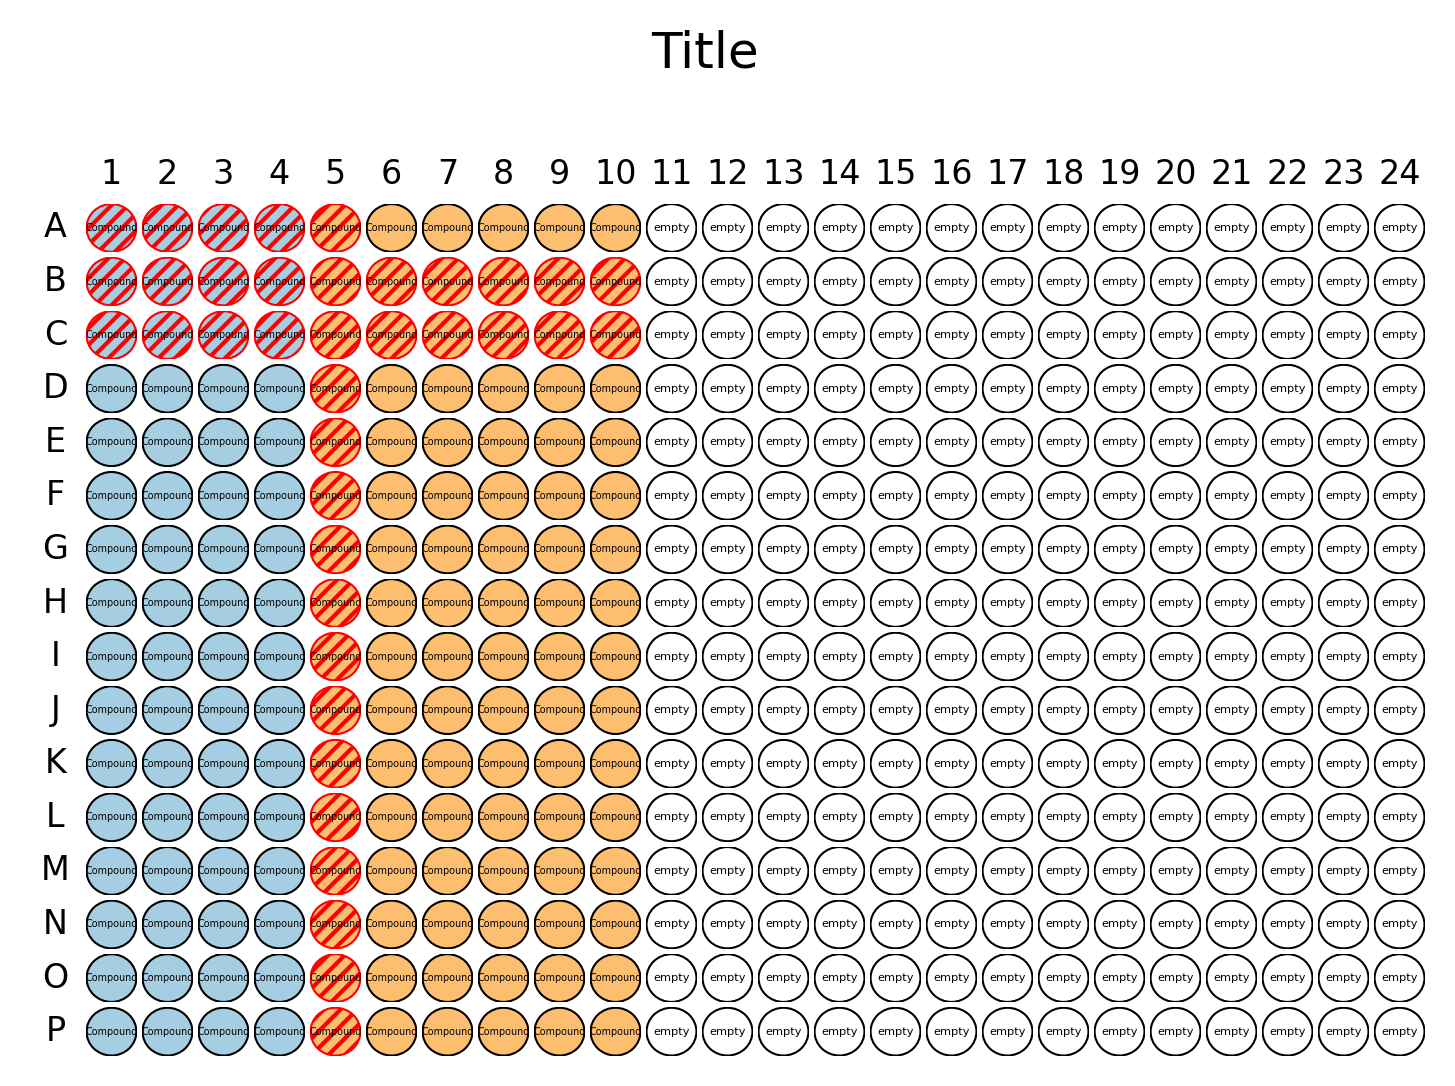

In [45]:
visualise(myplatemap, title = "Title", size = 384, export = False, cmap = 'Paired',
             colorby = 'Type', labelby = 'Contents', dpi = 300)